# Assignment part 2

## Introduction
Acetaminophen, commonly known as paracetamol, is a widely used over-the-counter analgesic (pain reliever) and antipyretic (fever reducer). It is commonly used for the relief of headaches, and other minor aches and pains, and is a major ingredient in numerous cold and flu remedies. After administration, acetaminophen is mainly metabolized in the liver by conjugation with glucuronic acid or sulfate. A minor pathway involves the formation of a reactive metabolite, N-acetyl-p-benzoquinone imine (NAPQI), which is detoxified by conjugation with glutathione. However, when glutathione is depleted, NAPQI can bind to cellular proteins, leading to hepatotoxicity. In general, acetaminophen is considered safe when taken at therapeutic doses. However, overdose can lead to severe liver damage. Using a physiologically-based pharmacokinetic (PBPK) model, we can simulate the pharmacokinetics of acetaminophen and its metabolites in different populations and under different dosing regimens, and study the effects of these factors on important pharmacokinetic parameters of acetaminophen.

In this assignment, you will be working in groups on a physiologically-informed model of paracetamol (acetaminophen or APAP), and two of its conjugates (acetaminophen-glucuronide or APAP-G and acetaminophen-sulfate or APAP-S). Additionally, the model contains a term that represents the formation of the toxic metabolite NAPQI, which can be obtained by computing this term from the model simulation outputs. The model is based on the following paper [Zurlinden, T. J., & Reisfeld, B. (2016)](https://doi.org/10.1007/s13318-015-0253-x)[^1]. 

This model is a large physiologically-based pharmacokinetic (PBPK) model. The model has 32 states and 56 parameters. As implementing such a model from scratch is a large task, we will be providing you with the model in the form of a Python script. An illustration of the model is given by:

![Model illustration](assets/acetaminophen_model.png)

### Assignment Task
In this assignment, your task is to perform experiments on a virtual population of patients. The detail of the model allows you to simulate the effect of different physiologies on the pharmacokinetics and relevant parameters. Additionally, you will be able to simulate the effect of different dosing regimens. For the assignment, you will need to choose a topic and formulate a research question that you want to answer using this model. You will then need to design experiments, adjusting the model and its parameters to answer this question. You will need to simulate the model for different (groups of) patients and/or dosing regimens, and analyze the results to answer your research question. 

You are free to choose any topic that you find interesting, but you should make sure that the research question is well-defined and that the experiments are designed to answer this question. Some examples of topics that you could choose are:
* The effect of impaired kidney function on the pharmacokinetics of acetaminophen and its metabolites and the consequences for dosage recommendations.
* The interaction between acetaminophen and phenobarbital, a drug that is used to treat epilepsy, which is known to block the formation of APAP-G [^2]. How would this interaction affect the amount of toxic NAPQI that is formed?
* Variability of the pharmacokinetics of acetaminophen in different populations (e.g., children, elderly, obese, etc.) and the consequences for dosage recommendations.

_Note: The above examples are just suggestions. You are free to choose any topic that you find interesting. Choosing an example topic has no negative influence on the grading of assignment over choosing your own topic._

### Assignment Deliverables
For this part of the assignment, you need to create a poster that presents the results of the experiments you have performed. The poster should contain information about the research question, the population you have simulated, the experiments you have performed, and the results of these experiments. The poster should be in A3 format. You can use any software to create the poster, but the final version should be handed in as a PDF file, as well as printed out and presented during the poster session. Additionally, you will need to submit all the code that you have used to perform the experiments. This code should be well-documented and should be able to reproduce the results that you have presented on the poster.

### Instructions on using the model
The model implementation is provided in the file `acetaminophen.py`. A model simulation can be set up in two steps. First, you will need a `.toml` file that contains the parameters for the patient that you want to simulate. An example of such a file is the `patient.toml` file. Using this file, you can call the `load_patient` function to generate a model that can be simulated. 

### A Note on units
The model is built to take inputs in `mg`, but the model internally uses micromoles (`umol`). The conversion is done internally, but you should be aware of this when interpreting the results. The model output units are as follows:
- Urine: `umol`
- GI: `mg`
- Others: `umol/L`

The function `umol2mg` can be used to convert the output to `mg`.

[^1]: Zurlinden, T. J., & Reisfeld, B. (2016). Physiologically based modeling of the pharmacokinetics of acetaminophen and its major metabolites in humans using a Bayesian population approach. European Journal of Drug Metabolism and Pharmacokinetics, 41(3), 267–280. https://doi.org/10.1007/s13318-015-0253-x
[^2]: Kostrubsky, S. E., Sinclair, J. F., Strom, S. C., Wood, S., Urda, E., Stolz, D. B., Wen, Y. H., Kulkarni, S., & Mutlib, A. (2005). Phenobarbital and phenytoin increased acetaminophen hepatotoxicity due to inhibition of UDP-glucuronosyltransferases in cultured human hepatocytes. Toxicological Sciences : An Official Journal of the Society of Toxicology, 87(1), 146–155. https://doi.org/10.1093/TOXSCI/KFI211

In [1]:
from acetaminophen import load_patient, COMPARTMENTS, umol_to_mg, additional_dose
from diffeqpy import ode
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.julia/environments/diffeqpy`


## Example Simulation
The rest of this notebook illustrates some functionality of working with the model.

We can load the `patient.toml` file and simulate the model for 14 hours after an oral dose of 1000 mg of paracetamol. This initial oral dose is part of the `patient.toml` file as the initial mass of drug in the `GI` compartment.

In [2]:
problem = load_patient("patient.toml")

We can run `ode.solve` on the problem that we obtain from `load_patient`. For this model, it is recommended to use the `ode.Rosenbrock23(autodiff=False)` solver, as it will be able to solve the problem faster than another solver such as `ode.Tsit5()`.

In [3]:
sol = ode.solve(problem, ode.Rosenbrock23(autodiff=False))

We can visualize the result below:

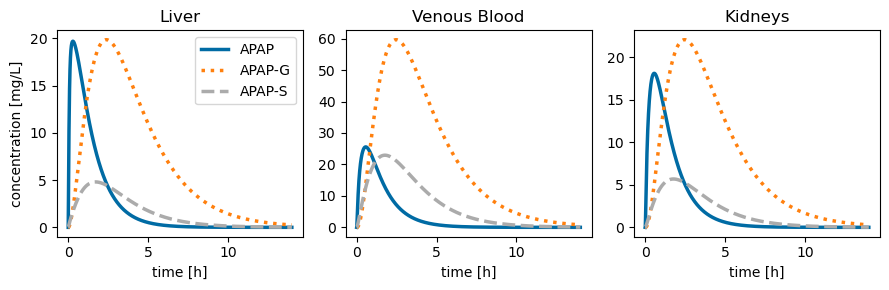

In [4]:
# visualize the solution
t = np.linspace(0.0,14.0,2000)
solution = np.array(sol(t))

fig, axs = plt.subplots(1,3, figsize=(9,3))
titles = ["Liver", "Venous Blood", "Kidneys"]
# venous blood
for i, compartment in enumerate(["liver", "venous_blood", "kidneys"]):
  axs[i].plot(t, umol_to_mg(solution[:,COMPARTMENTS[compartment]["acetaminophen"]], "acetaminophen"), label="APAP", ls='-', lw=2.5)
  axs[i].plot(t, umol_to_mg(solution[:,COMPARTMENTS[compartment]["acetaminophen_G"]], "acetaminophen_G"),  label="APAP-G", ls=':', lw=2.5)
  axs[i].plot(t, umol_to_mg(solution[:,COMPARTMENTS[compartment]["acetaminophen_S"]], "acetaminophen_S"),  label="APAP-S", ls="--", lw=2.5)
  axs[i].set_title(titles[i])
  axs[i].set_xlabel("time [h]")
axs[0].set_ylabel("concentration [mg/L]")
axs[0].legend()
plt.tight_layout()


## Simulating IV-administration
We can also simulate the model for an intravenous (IV) dose of paracetamol. We can do this by setting the `D_iv` parameter to the desired rate of infusion. Let's simulate an infusion of 250mg over 2 hours after 1 hour. Which means we'll need a 2-hour infusion with a constant rate of 125mg/h. Using callbacks, we can turn the infusion on and off at the desired times. Observe the following code for an example of how to do this.

In [5]:
# Define two callbacks, one to turn the iv on, and one to turn the iv off again.
def condition_iv_on(u, t, integrator):
  return t == 1

def affect_iv_on_b(integrator):
  integrator.p[57] += 125 # we can add this in mg/h. The model automatically converts this to micromoles.

def condition_iv_off(u, t, integrator):
  return t == 3

def affect_iv_off_b(integrator):
  integrator.p[57] -= 125

iv_on = ode.DiscreteCallback(condition_iv_on, affect_iv_on_b)
iv_off = ode.DiscreteCallback(condition_iv_off, affect_iv_off_b)

# create a callbackset to combine both callbacks in
callbacks = ode.CallbackSet(iv_on, iv_off)

In [6]:
sol_iv = ode.solve(problem, ode.Rosenbrock23(autodiff=False), callback=callbacks, tstops=[1,3])

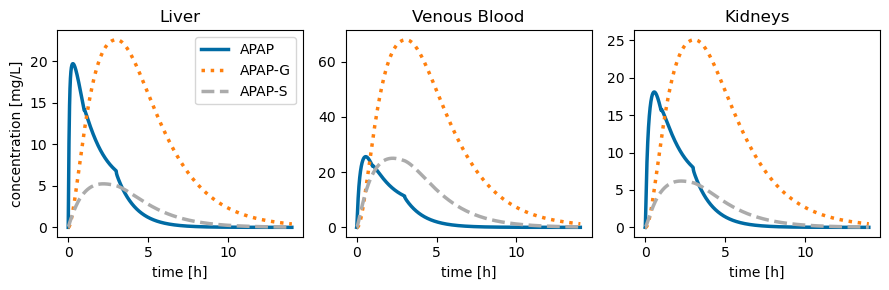

In [7]:
# visualize the solution
t = np.linspace(0.0,14.0,2000)
solution_iv = np.array(sol_iv(t))

fig, axs = plt.subplots(1,3, figsize=(9,3))
titles = ["Liver", "Venous Blood", "Kidneys"]
# venous blood
for i, compartment in enumerate(["liver", "venous_blood", "kidneys"]):
  axs[i].plot(t, umol_to_mg(solution_iv[:,COMPARTMENTS[compartment]["acetaminophen"]], "acetaminophen"), label="APAP", ls='-', lw=2.5)
  axs[i].plot(t, umol_to_mg(solution_iv[:,COMPARTMENTS[compartment]["acetaminophen_G"]], "acetaminophen_G"),  label="APAP-G", ls=':', lw=2.5)
  axs[i].plot(t, umol_to_mg(solution_iv[:,COMPARTMENTS[compartment]["acetaminophen_S"]], "acetaminophen_S"),  label="APAP-S", ls="--", lw=2.5)
  axs[i].set_title(titles[i])
  axs[i].set_xlabel("time [h]")
axs[0].set_ylabel("concentration [mg/L]")
axs[0].legend()
plt.tight_layout()

## Simulating additional oral doses

Simulating an additional oral dose is slightly more complicated. For this, we'll have to perform multiple simulations. We can start with an initial dose and simulate the model until 6 hours.

In [8]:
sol_initial_dose = ode.solve(problem, ode.Rosenbrock23(autodiff=False), tspan=(0., 6))

Using the `additional_dose` function, we can define a new problem that introduces an additional dose based on the initial dose solution. This second solution will then start at the end of the first solution. We can then concatenate the two solutions to get a single solution that contains the results of both simulations.

In [9]:
problem_additional_dose = additional_dose(sol_initial_dose, problem, dose=500., t_dose=6.)
sol_second_dose = ode.solve(problem_additional_dose, ode.Rosenbrock23(autodiff=False), tspan=(6., 14.))

We now have two solutions in two parts of the time span. Let's interpolate both and combine them into a single solution.

In [10]:
solution_initial_dose = np.array(sol_initial_dose(np.linspace(0.0,6.0,1000)))
solution_second_dose = np.array(sol_second_dose(np.linspace(6.0,14.0,1000)))

# we skip the first entry of the second dose, as the timepoints both contain 6 there
timepoints = np.concatenate([np.linspace(0.0,6.0,1000), np.linspace(6.0,14.0,1000)[1:]])
solution_both_doses = np.concatenate([solution_initial_dose, solution_second_dose[1:,:]], axis=0)

We can finally visualize our results.

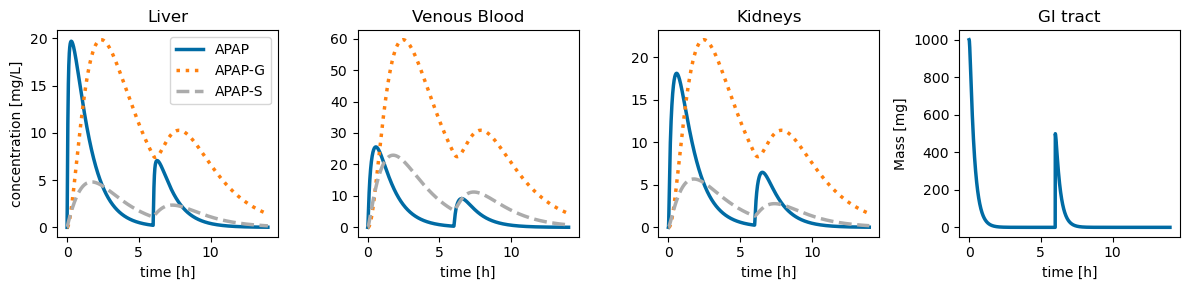

In [11]:
# visualize the solution
t = timepoints

fig, axs = plt.subplots(1,4, figsize=(12,3))
titles = ["Liver", "Venous Blood", "Kidneys"]
# venous blood
for i, compartment in enumerate(["liver", "venous_blood", "kidneys"]):
  axs[i].plot(t, umol_to_mg(solution_both_doses[:,COMPARTMENTS[compartment]["acetaminophen"]], "acetaminophen"), label="APAP", ls='-', lw=2.5)
  axs[i].plot(t, umol_to_mg(solution_both_doses[:,COMPARTMENTS[compartment]["acetaminophen_G"]], "acetaminophen_G"),  label="APAP-G", ls=':', lw=2.5)
  axs[i].plot(t, umol_to_mg(solution_both_doses[:,COMPARTMENTS[compartment]["acetaminophen_S"]], "acetaminophen_S"),  label="APAP-S", ls="--", lw=2.5)
  axs[i].set_title(titles[i])
  axs[i].set_xlabel("time [h]")
axs[3].plot(t, solution_both_doses[:,COMPARTMENTS["GI"]["acetaminophen"]], lw=2.5)
axs[3].set_title("GI tract")
axs[3].set_xlabel("time [h]")
axs[0].set_ylabel("concentration [mg/L]")
axs[3].set_ylabel("Mass [mg]")
axs[0].legend()
plt.tight_layout()

## Simulating a population
For simulating a population, you will need to create multiple patients and simulate them. However, instead of creating many `.toml` files manually, you can create a single `.toml` file that contains the population mean. You can then simulate the population by adding random variability to (some of) the parameters. In this example, we will simulate a small population of 50 patients, of which `patient.toml` is the population mean. In this case, we will add random variability to the patients' body weight, which automatically impacts many of the parameters, such as the volumes of the compartments, and the blood flow rates.

In [12]:
mean_problem = load_patient('patient.toml')
mean_parameters = mean_problem.p
body_weight_sd = 6.8 # standard deviation of 6.8 kg
body_weights = np.array([mean_problem.p[1]] * 50) + np.random.randn(50) * body_weight_sd  

t = np.linspace(0,14,2000)
solutions = []
for body_weight in body_weights:
  mean_parameters[1] = body_weight
  sol = ode.solve(mean_problem, ode.Rosenbrock23(autodiff=False), p=mean_parameters)
  solutions.append(np.array(sol(t)))

No we can visualize the solution for the population.

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(9,3))
titles = ["Liver", "Venous Blood", "Kidneys"]
# venous blood
for i, compartment in enumerate(["liver", "venous_blood", "kidneys"]):
  for solution in solutions:
    axs[i].plot(t, umol_to_mg(solution[:,COMPARTMENTS[compartment]["acetaminophen"]], "acetaminophen"), label="APAP", ls='-', alpha=0.2, lw=2.5, c='xkcd:cerulean')
    axs[i].plot(t, umol_to_mg(solution[:,COMPARTMENTS[compartment]["acetaminophen_G"]], "acetaminophen_G"),  label="APAP-G", ls='-', alpha=0.2, lw=2.5, c='xkcd:faded orange')
    axs[i].plot(t, umol_to_mg(solution[:,COMPARTMENTS[compartment]["acetaminophen_S"]], "acetaminophen_S"),  label="APAP-S", ls="-", alpha=0.2, lw=2.5, c='xkcd:cool grey')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("time [h]")
axs[0].set_ylabel("concentration [mg/L]")
plt.tight_layout()

By simulating a population, you can more realistically assess the variability in the pharmacokinetics between different patient groups.